In [12]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/internet-service-churn/internet_service_churn.csv


# Description of Datasets
There is a big competition between Internet providers. If a providers want to increase its revenue they needs more subscriber but keep existing customer is more important than having new ones. So providers want to know which customer should cancel his service. we call this as churn. if the know who will go, maybe they can catch them with promotions.

This csv file contains basic information for internet service subscriber. The goal is to find a subscriber will churn or not.

- id
unique subscriber id

- is_tv_subscriber
customer has a tv subscription ?

- is_movie_package_subscriber
is he/she has a sinema movie package subs

- subscription_age
how many year has the customer use our service

- bill_avg
last 3 months bill avg

- reamining_contract
how many year remaining for customer contract. if null; customer hasnt have a contract. the customer who has a contract time have to use their service until contract end. if they canceled their service before contract time end they pay a penalty fare.

- service_failure_count
customer call count to call center for service failure for last 3 months

- download_avg
last 3 months internet usage (GB)

- upload_avg
last 3 months upload avg (GB)

- download_over_limit
most of customer has a download limit. if they reach this limit they have to pay for this. this column contain "limit over count" for last 9 months

- churn
this is the target column. if 1 customer canceled his service

In [13]:
#importing necessary library
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score ,cross_validate, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import plotly.figure_factory as ff
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, auc, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [14]:
def wrangle(path):
    return pd.read_csv(path)

In [15]:
df=pd.read_csv('/kaggle/input/internet-service-churn/internet_service_churn.csv')
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


# Main Objectives of the analysis
The main objective of the Project is to understand and built a model using the customer churn dataset of the internet service provider is to predict whether a subscriber is likely to churn or not. This model aims to leverage the provided customer information to accurately classify subscribers into two categories: those who are likely to cancel their service (churn) and those who are likely to remain as customers. By achieving this prediction, the model will assist the internet service provider in proactively identifying potential churn cases, allowing them to implement targeted retention strategies such as personalized promotions, offers, or interventions to mitigate customer attrition and ultimately increase customer retention rates.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


In [17]:
df.drop(columns='id',inplace=True)

## Checking Missing Values

In [18]:
def check_missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [19]:

check_missing_values(df)

,Missing_Number,Missing_Percent
reamining_contract,21572,29.847525
download_avg,381,0.527161
upload_avg,381,0.527161
is_tv_subscriber,0,0.000000
is_movie_package_subscriber,0,0.000000
subscription_age,0,0.000000
bill_avg,0,0.000000
service_failure_count,0,0.000000
download_over_limit,0,0.000000
churn,0,0.000000


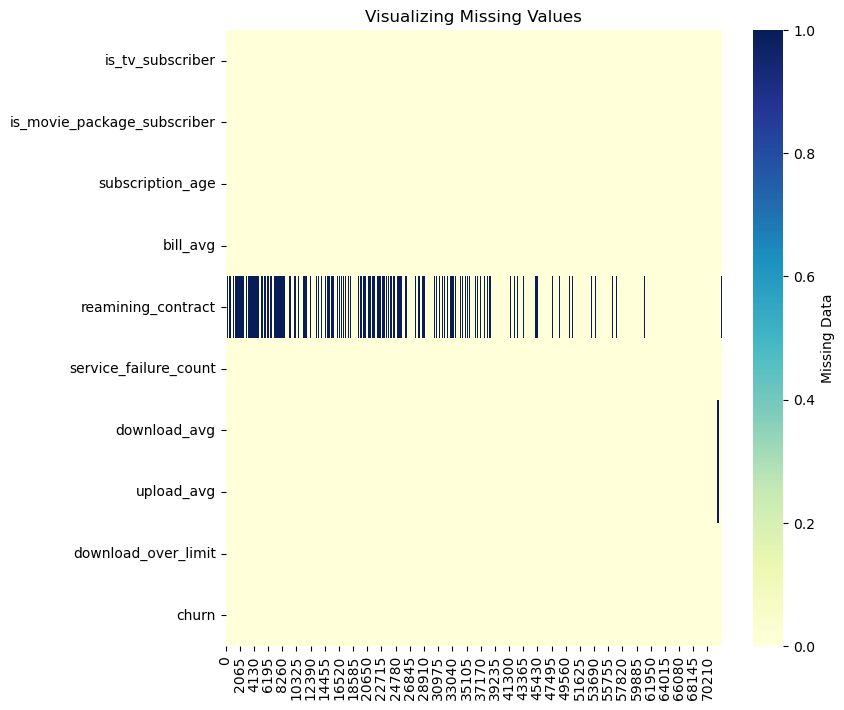

In [20]:
plt.figure(figsize=(8,8))
plt.title('Visualizing Missing Values')
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

### Missing value summary
- The `remaining_contract` column has 29.84% missing values, which corresponds to 21,572 missing entries.
- Both the`download_avg` and 'upload_avg' columns have 0.52% missing values, which amounts to 381 missing entries.
- The dark-blue color in above `Heatmap` also shows the number of missing value. More the dark-blue color is, higher the chance of missing value is and vice-versa

# Categorical Column's Univariate Analysis

In [21]:
df['is_tv_subscriber'].value_counts().tolist()

[58922, 13352]

In [22]:
df['is_tv_subscriber'].value_counts().index.tolist()

[1, 0]

In [23]:
original_df = df.copy()

In [24]:
#Counting the categories in each column
def categories_count(data,col_name):
    if(data[col_name].nunique()<=2):
        data[col_name] = data[col_name].replace((1,0),("Yes","No"))
    count = data[col_name].value_counts().tolist()
    categories = data[col_name].value_counts().index.tolist()
    value_count_df = pd.DataFrame({"Column_Name" : categories, "Count":count})
    return value_count_df

In [25]:
#ploting Univariate figure
def univariate_barplot(data,xlabel):
    print(data.head())
    if(data['Column_Name'].nunique()<=2):
        ax = plt.figure(figsize=(5,5))
    else:
        ax = plt.figure(figsize=(15,6))
    ax = sns.barplot()
    ax = sns.barplot(x='Column_Name',y ='Count',data = data)
    ax.set_title(f"Distribution of {xlabel}")
    ax.set(xlabel=xlabel,ylabel="Frequency")
    total = data['Count'].sum()
    for p in ax.patches:
        height = p.get_height()
        height_percent = "{:.2f}%".format((height/total)*100)
        ax.text(p.get_x()+p.get_width()/2., height + 5,height_percent ,ha="center")
    plt.show()

### Is customer a Tv subscriber also? <br><br>1:Yes , 0:No

  Column_Name  Count
0         Yes  58922
1          No  13352
  Column_Name  Count
0         Yes  58922
1          No  13352


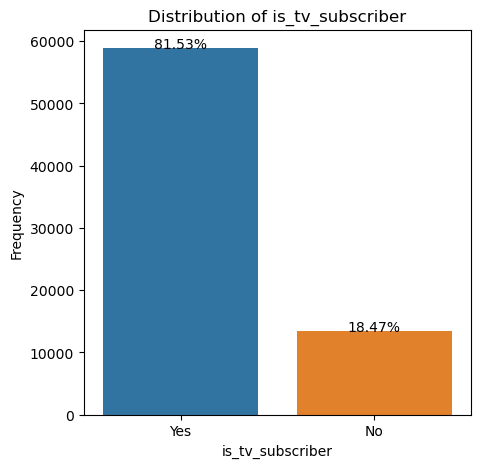

In [26]:
tvCount_df = categories_count(df,'is_tv_subscriber')
print(tvCount_df.head())
univariate_barplot(tvCount_df,xlabel='is_tv_subscriber')

  Column_Name  Count
0          No  48089
1         Yes  24185


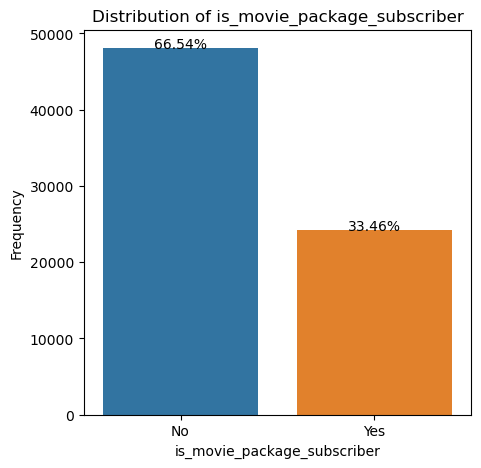

In [27]:
movie_package_subscriber_df = categories_count(df,'is_movie_package_subscriber')
univariate_barplot(movie_package_subscriber_df,xlabel='is_movie_package_subscriber')

   Column_Name  Count
0            0  60407
1            1   7665
2            2   2453
3            3    901
4            4    395


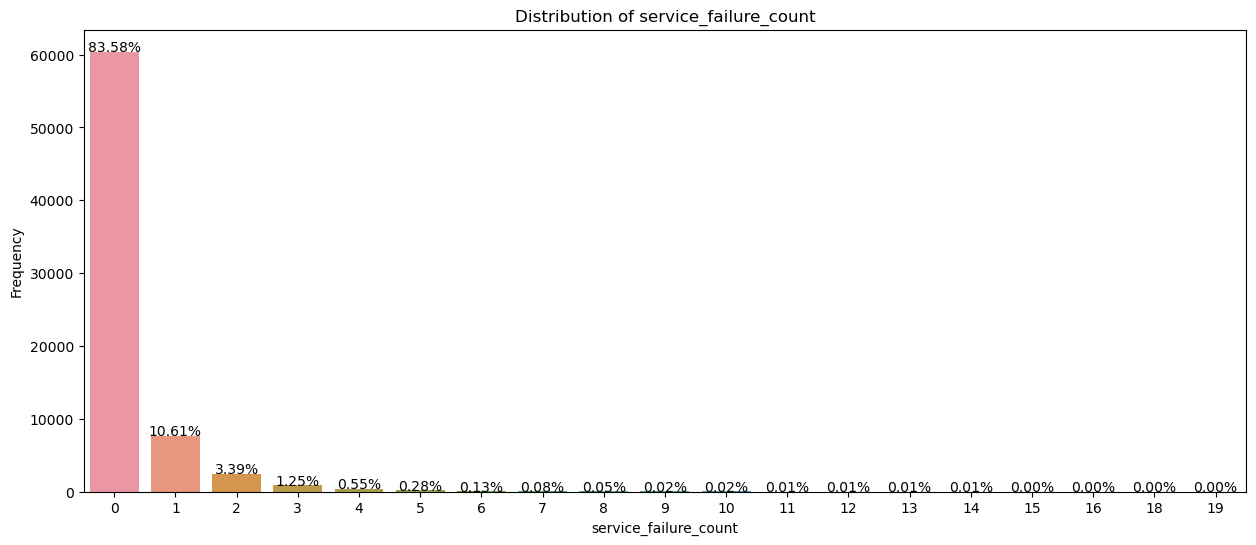

In [28]:
service_failure_count_df = categories_count(df,'service_failure_count')
univariate_barplot(service_failure_count_df,xlabel='service_failure_count')

   Column_Name  Count
0            0  68373
1            1    766
2            6    688
3            2    560
4            7    504


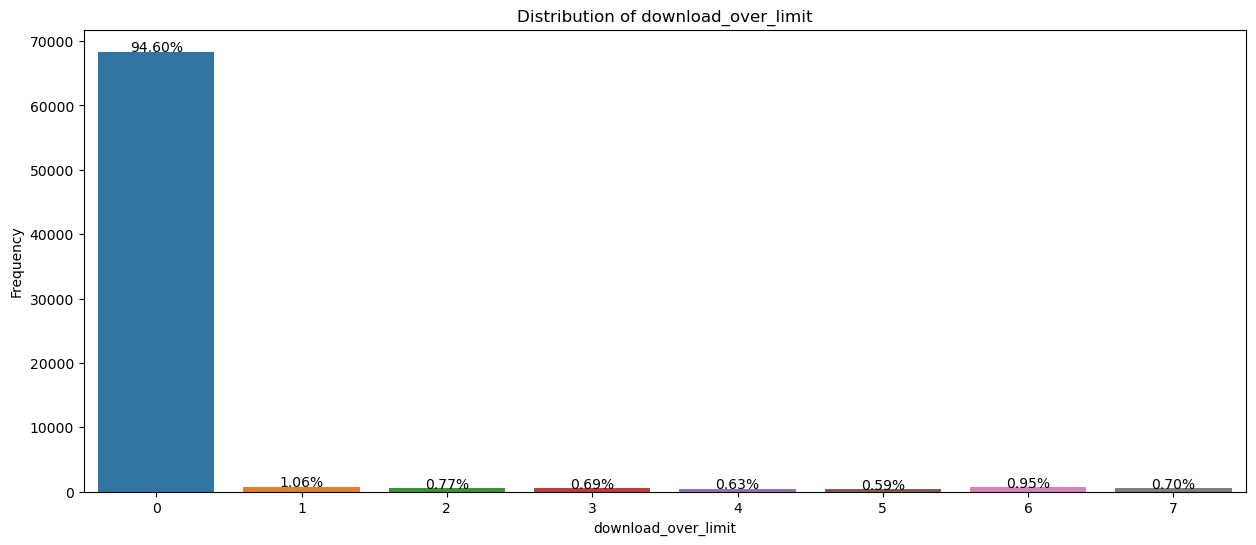

In [29]:
download_over_limit_df = categories_count(df,'download_over_limit')
univariate_barplot(download_over_limit_df,xlabel='download_over_limit')

  Column_Name  Count
0         Yes  40050
1          No  32224


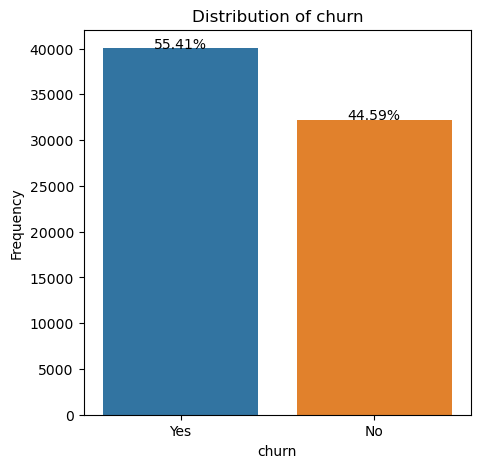

In [30]:
customer_churn = categories_count(df,'churn')
univariate_barplot(customer_churn,xlabel='churn')

# Feature Engineering

#### How likely is `is_tv_subscriber` could be a `is_movie_package_subscriber` ?

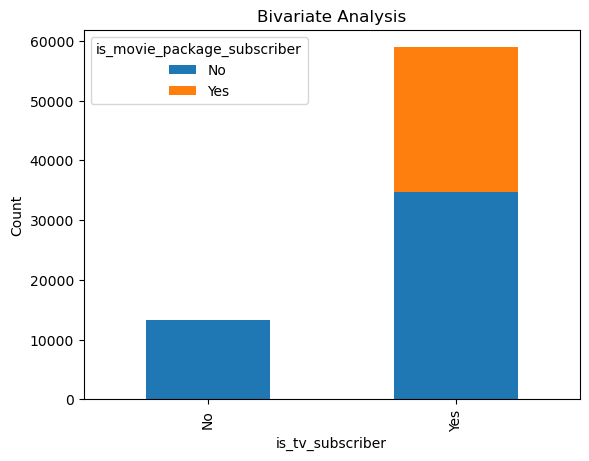

is_movie_package_subscriber,No,Yes
is_tv_subscriber,,
No,13350,2
Yes,34739,24183


In [31]:
# Create a contingency table
contingency_table = pd.crosstab(df['is_tv_subscriber'], df['is_movie_package_subscriber'])

# Plot a stacked bar chart
contingency_table.plot(kind='bar', stacked=True)

# Set labels and title
plt.xlabel('is_tv_subscriber')
plt.ylabel('Count')
plt.title('Bivariate Analysis')

# Display the plot
plt.show()
contingency_table

In [32]:
original_df.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,0,0,6.39,0,NaN,0,0.0,0.0,0,1


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


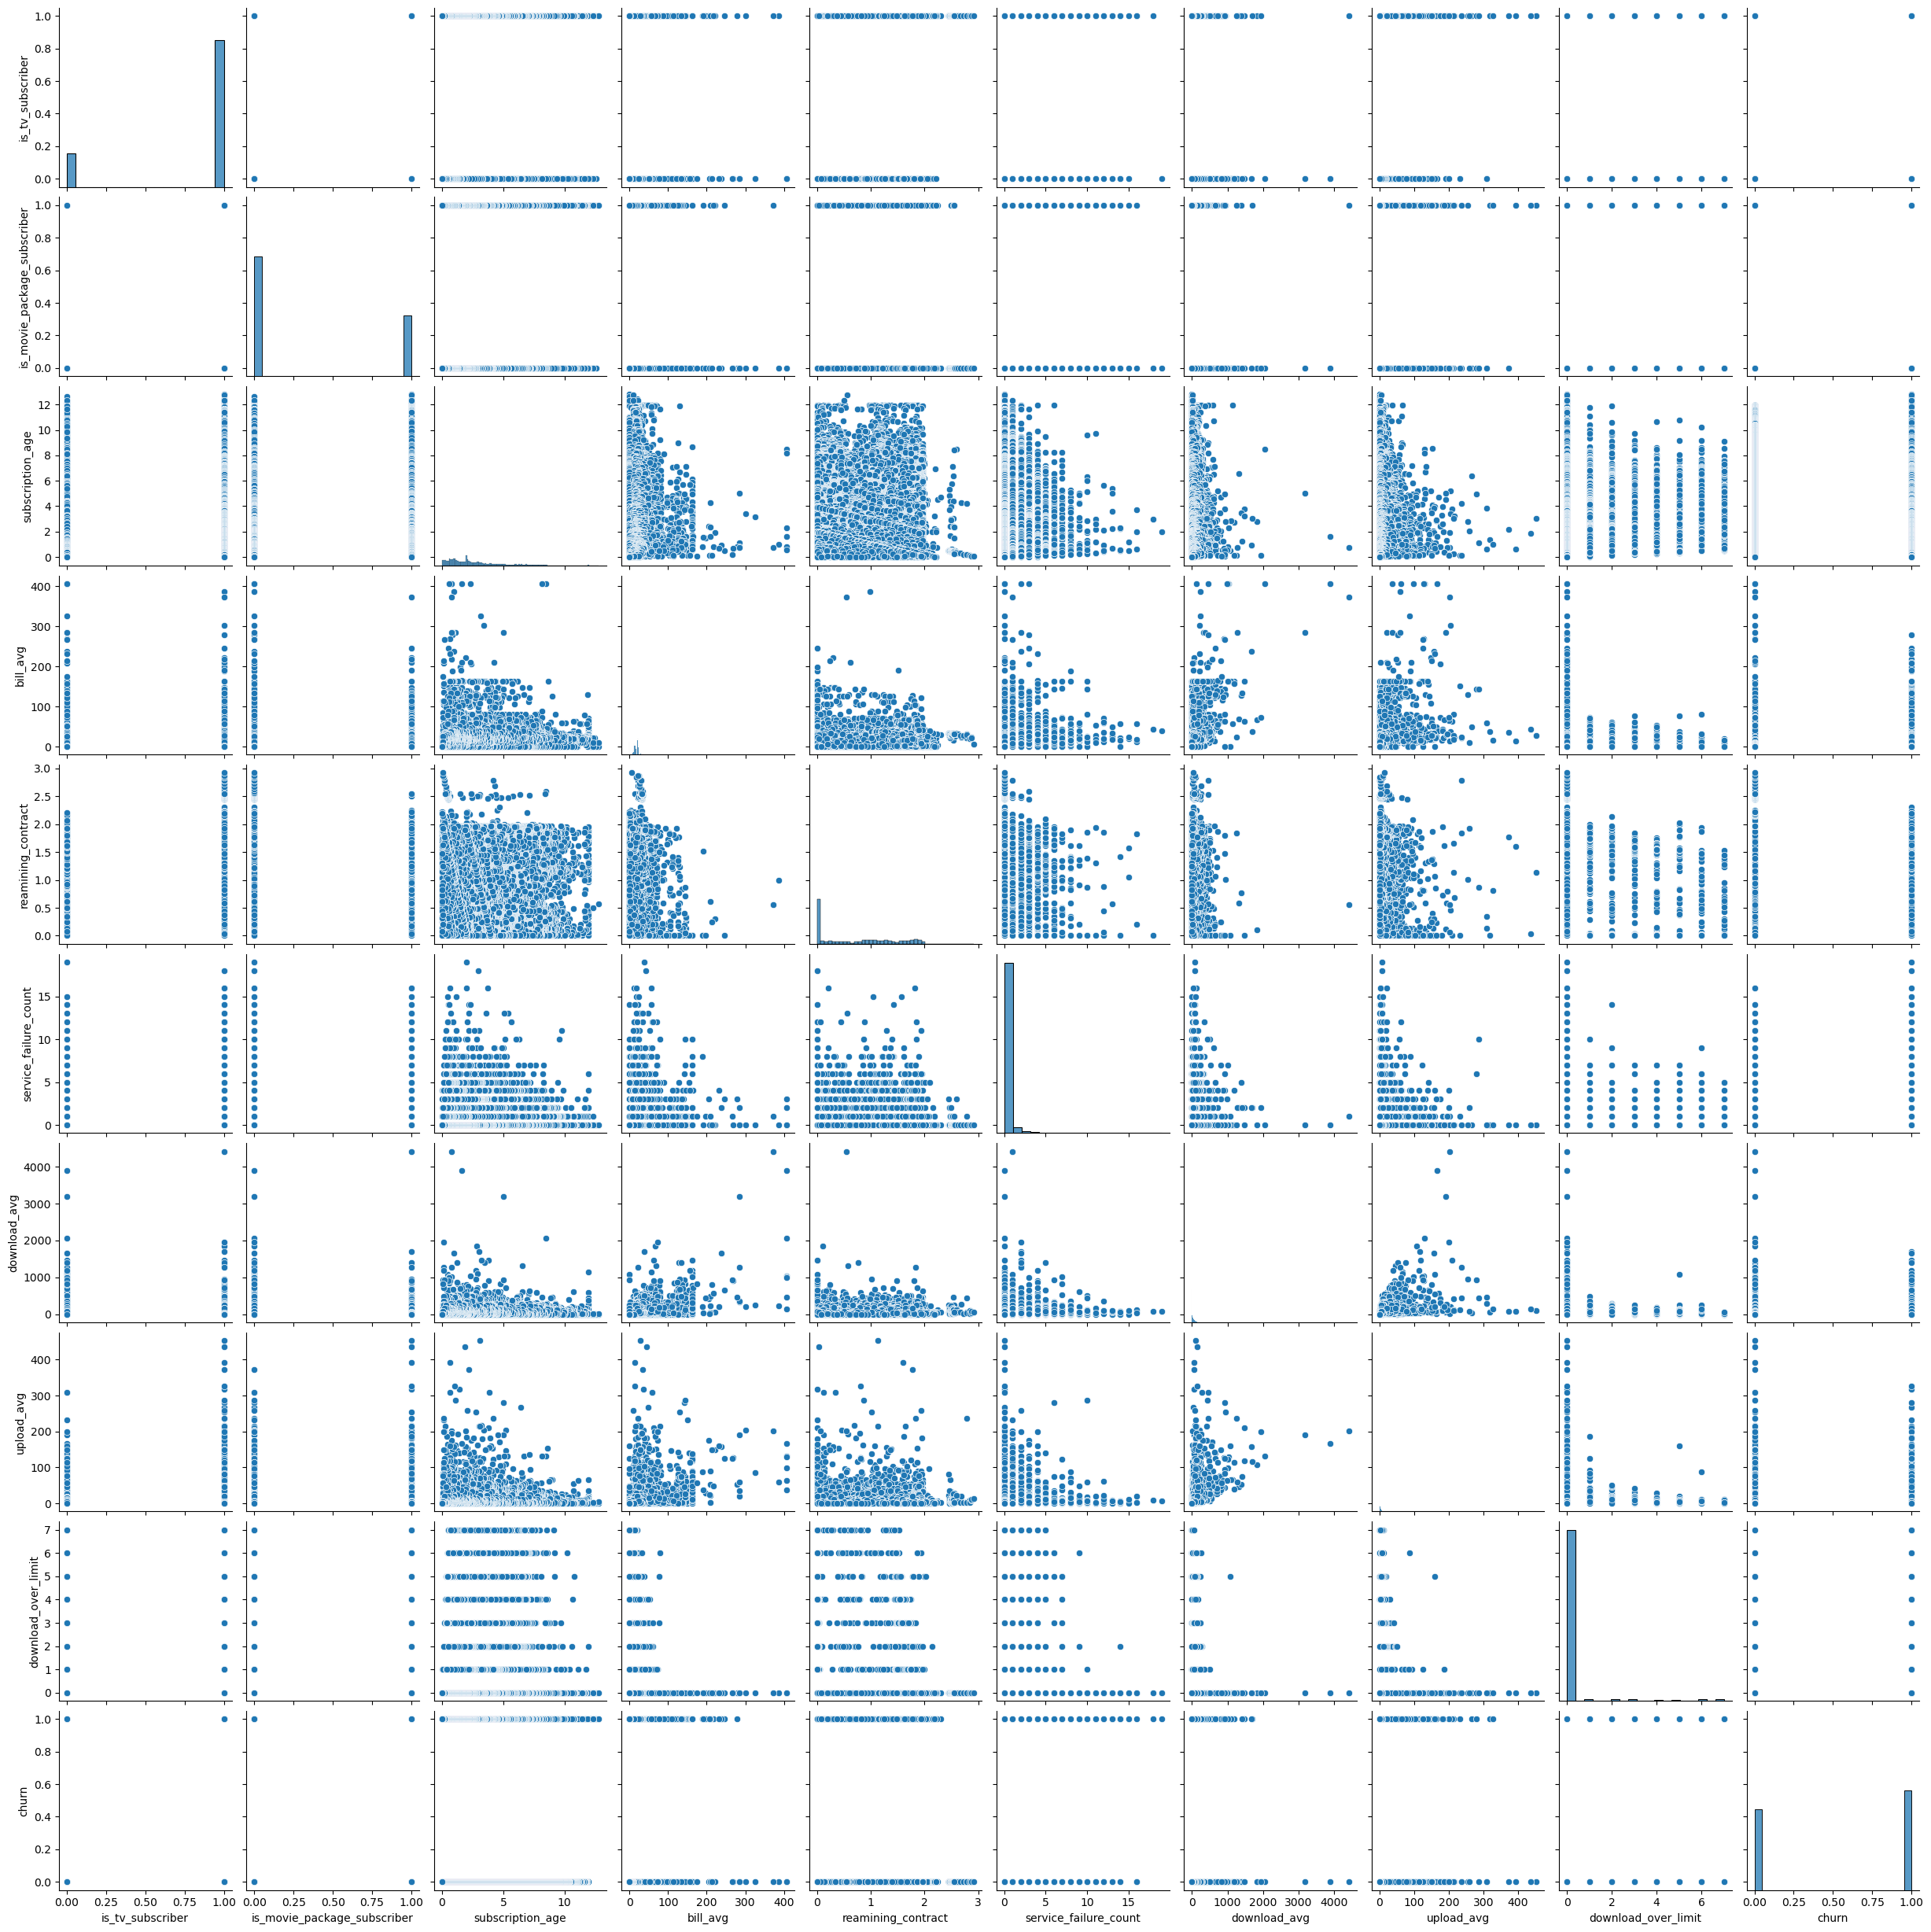

In [33]:
sns.pairplot(original_df)

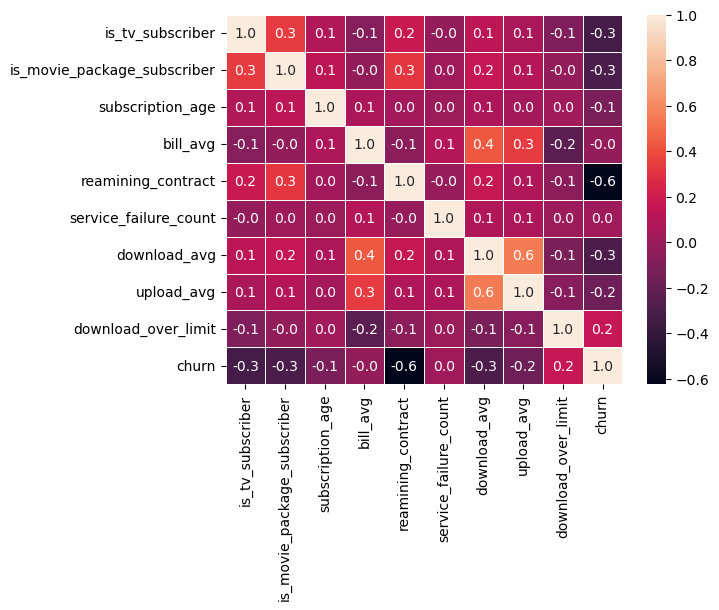

In [34]:
sns.heatmap(original_df.corr(),annot=True, fmt=".1f",  linewidth=.5);

### Heatmap Summary
- Target Feature `Churn` is negatively correlated with tv subscriber and movie package subscriber
- Remaining time of contract is highly-positively correlated to target variable
- Unfortunately, we can see that most of the feature are weekly correlated with target feature. Even it has no correlation with out two feature<br>
### We will be doing further analysis for selecting the features

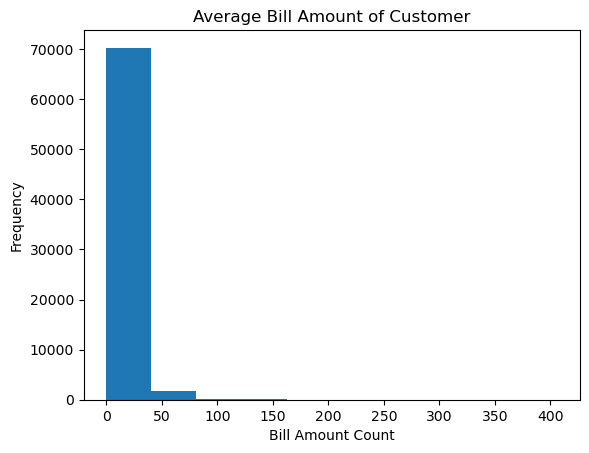

In [35]:
plt.hist(original_df['bill_avg'])
plt.xlabel("Bill Amount Count")
plt.ylabel("Frequency");
plt.title("Average Bill Amount of Customer");

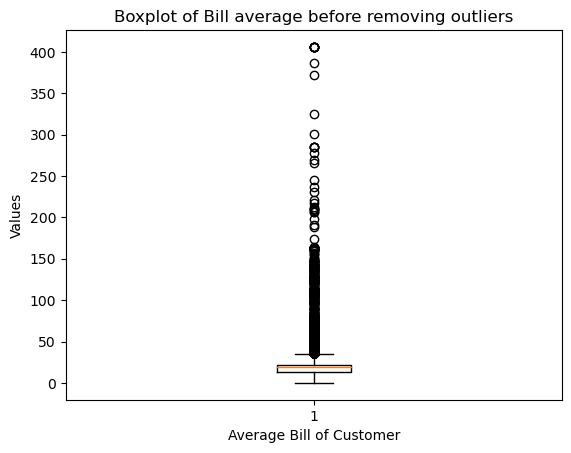

In [36]:
#boxplot of average bill column before handling outliers
plt.boxplot(original_df['bill_avg'])
plt.xlabel("Average Bill of Customer")
plt.ylabel("Values")
plt.title("Boxplot of Bill average before removing outliers");

In [37]:
higher = original_df['bill_avg'].quantile(0.9)
lower = original_df['bill_avg'].quantile(0.1)
print(f"Higher Quantile is {higher}")
print(f"Lower Quantile is {lower}")
print(f"There are {(original_df['bill_avg']>higher).sum()} data above higher quantile")
print(f"There are {(original_df['bill_avg']<lower).sum()} data less than lower quantile")

Higher Quantile is 28.0
Lower Quantile is 8.0
There are 6793 data above higher quantile
There are 6963 data less than lower quantile


### As there are high number of observation below and above the selected quantile, lets use caping technique instead of treaming fot removing outliers.

In [38]:
original_df['bill_avg'] = np.where(
    original_df['bill_avg']>higher,
    higher,
    np.where(
        original_df['bill_avg']<lower,
        lower,
        original_df['bill_avg']
    )
)
original_df['bill_avg'].max(),df['bill_avg'].min()

(28.0, 0)

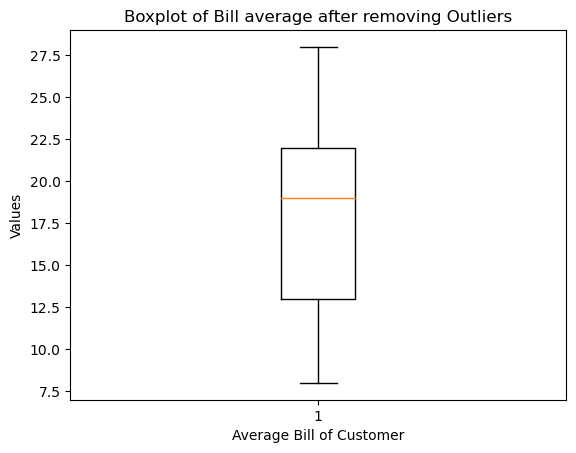

In [39]:
#boxplot of average bill column after handling outliers
plt.boxplot(original_df['bill_avg'])
plt.xlabel("Average Bill of Customer")
plt.ylabel("Values")
plt.title("Boxplot of Bill average after removing Outliers");

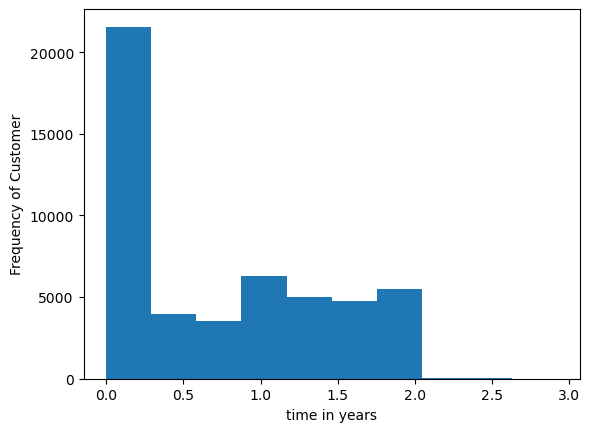

In [40]:
plt.hist(original_df["reamining_contract"])
plt.ylabel("Frequency of Customer")
plt.xlabel("time in years");

### Remaining Contract Summary
- Customer has maximum of 2.5 yrs of contract but there are very less customer at this range. So, we can cap the data to 2 years
- Most of the Customer has contract of first 3-4 month, SO the distribution is left skewed
- Since the dsitribution is left-skewed, we can fill the missing data with the median

In [41]:
# Caping the remaining contract greater than 2 years to 2 years
original_df['reamining_contract'] = np.where(
    original_df['reamining_contract']>2,
    2,
    original_df['reamining_contract']
)

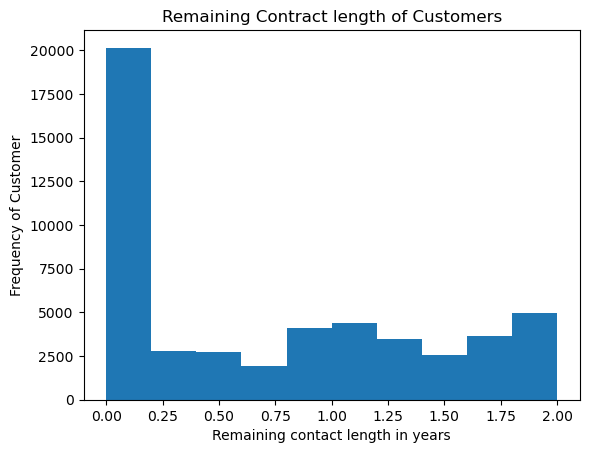

In [42]:
plt.hist(original_df["reamining_contract"])
plt.ylabel("Frequency of Customer")
plt.xlabel("Remaining contact length in years");
plt.title("Remaining Contract length of Customers");

In [43]:
#filling Missing Values with median
original_df['reamining_contract'].fillna(original_df['reamining_contract'].median(), inplace =True)

In [44]:
original_df.isna().sum()

is_tv_subscriber                 0
is_movie_package_subscriber      0
subscription_age                 0
bill_avg                         0
reamining_contract               0
service_failure_count            0
download_avg                   381
upload_avg                     381
download_over_limit              0
churn                            0
dtype: int64

#### We can see, average download and average upload column still has equal number of missing values. We will handle it later through pipeline using simpleImputer with its default value.

In [45]:
original_df['download_avg'].fillna(np.mean(df['download_avg']),inplace=True)
original_df['upload_avg'].fillna(np.mean(df['upload_avg']),inplace=True)

In [46]:
X = original_df.drop(columns='churn')
y = original_df['churn']

# Brief summary of data exploration and actions taken for data cleaning and feature engineering.

1. **Subscription Patterns:**
   - The majority of customers are not subscribed to either TV services or movie packages.
   - Instances of customers subscribing to both TV services and movie packages are very rare.

2. **Service Failure Impact:**
   - Approximately 17% of the customers have reported experiencing service failure issues.
   - This highlights a significant concern that requires careful consideration.

3. **Download Limit Crossings:**
   - Around 7% of the customers have exceeded their internet download limits.
   - This indicates a potential pain point that could contribute to customer dissatisfaction.

4. **Contract Length Influence:**
   - The remaining length of a customer's contract has a substantial positive impact on their likelihood to churn.
   - Longer remaining contract lengths are associated with a higher probability of customer retention.

5. **Feature Engineering and Missing Values:**
   - During feature engineering, missing values in columns such as remaining contract length, upload average, and download average have been imputed using the range between the 1st and 9th quantiles.
   - This approach helps maintain data integrity and enables better model performance.

These findings provide valuable insights for building a predictive model to identify potential churn cases and implement effective retention strategies for the internet service provider's subscribers.


# Splitting the data

In [47]:
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Evaluation

In [48]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [49]:
# L1 penalty to shrink coefficients without removing any features from the model
penalty= 'l1'

# Use saga for L1 penalty and multinomial classes
solver = 'liblinear'

In [50]:
input_steps = [
    ('scaler', StandardScaler()),
    ('polynomialfeatures',PolynomialFeatures(degree=2)),
    ('classifier', LogisticRegression(random_state=42, penalty=penalty,solver=solver, max_iter = 1000)) # Step 3: LogisticRegression
]

model_lr = Pipeline(steps=input_steps)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('classifier',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [51]:
y_pred = model_lr.predict(X_test)
y_pred[:5]

array([1, 1, 0, 0, 1])

In [52]:
evaluate_metrics(y_test,y_pred)

{'accuracy': 0.8457973019716362,
 'recall': array([0.79948115, 0.88420653]),
 'precision': array([0.85131622, 0.84170582]),
 'f1score': array([0.82458487, 0.86243288])}

In [53]:
# Calculate and display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      6553
           1       0.84      0.88      0.86      7902

    accuracy                           0.85     14455
   macro avg       0.85      0.84      0.84     14455
weighted avg       0.85      0.85      0.85     14455



In [54]:
def plot_confusion_matrix(y_test,y_pred,Algorithm):
    # Assuming y_test and y_pred are your actual and predicted labels
    cm = confusion_matrix(y_test, y_pred)

    class_names = ['Churn', 'Not Churn']  # Replace with your class names

    fig = ff.create_annotated_heatmap(cm, x=class_names, y=class_names)
    fig.update_layout(title=f'Confusion Matrix of {Algorithm}',
                      xaxis=dict(title='Predicted'),
                      yaxis=dict(title='Actual'))
    fig.show()

In [55]:
plot_confusion_matrix(y_test,y_pred,"Logistic Regression")

In [56]:
def plot_ROC_curve(model,Algorithm):
    # Get predicted probabilities from the model pipeline
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve of {Algorithm}')
    plt.legend(loc='lower right')
    plt.show()

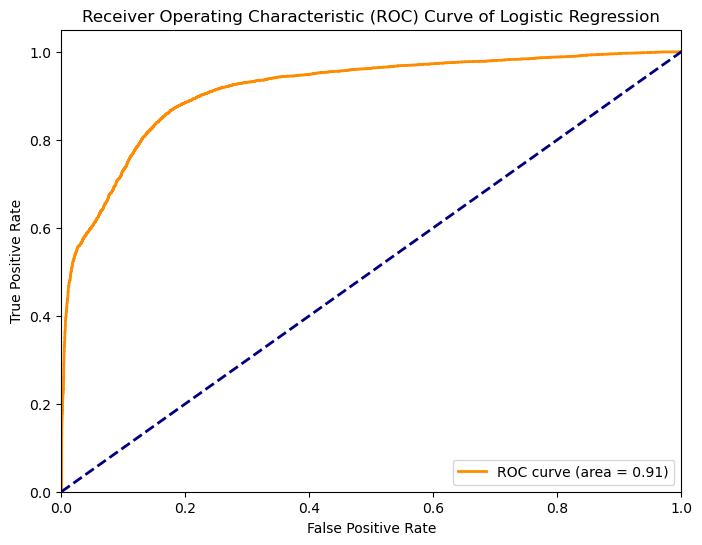

In [57]:
plot_ROC_curve(model_lr,'Logistic Regression')

## Logistic Regression with PCA

In [58]:
# Define the pipeline steps
input_steps = [
    ('scaler', StandardScaler()),                      # Step 1: StandardScaler
    ('pca', PCA(n_components=0.8)),                    # Step 2: PCA
    ('logisticregression', LogisticRegression(random_state=42, max_iter=1000))  # Step 3: Logistic Regression
]

# Create the pipeline
model_pipeline = Pipeline(steps=input_steps)

# Fit the pipeline to your training data
model_pipeline.fit(X_train, y_train)

# Make predictions on the testing data using the fitted pipeline
y_pred_pca = model_pipeline.predict(X_test)

In [59]:
evaluate_metrics(y_test,y_pred_pca)

{'accuracy': 0.7910757523348322,
 'recall': array([0.71951778, 0.85041762]),
 'precision': array([0.7995591 , 0.78523019]),
 'f1score': array([0.75742972, 0.81652491])}

## K-Nearest Neighbours

In [60]:
# Custom labels for the metrics
scoring = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1-Score': 'f1',  
}

cv = KFold(n_splits=5)
cv_results = cross_validate(model_lr, X, y, cv=cv, scoring=scoring, return_train_score=True, n_jobs=-1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Let’s convert the output scores to pandas DataFrame and transpose to display properly

In [61]:
scores = pd.DataFrame(cv_results, index=range(1, 6))
scores.index.name = 'Fold'
scores.columns.name = 'Scores'
scores.round(4).transpose()

Fold,1,2,3,4,5
Scores,,,,,
fit_time,6.6802,7.2639,19.1448,4.8236,31.7841
score_time,0.0565,0.0560,0.0366,0.0604,0.0310
test_Accuracy,0.8334,0.8939,0.8268,0.7050,0.7339
train_Accuracy,0.8310,0.8308,0.8492,0.8768,0.8481
test_Precision,0.9974,0.9373,0.8129,0.5923,0.4108
train_Precision,0.8269,0.8238,0.8485,0.8868,0.8626
test_Recall,0.7959,0.9243,0.9143,0.8559,0.6910
train_Recall,0.8291,0.8415,0.8815,0.9078,0.9079
test_F1-Score,0.8853,0.9307,0.8606,0.7001,0.5153


In [62]:
scores.mean()

Scores
fit_time           13.939332
score_time          0.048086
test_Accuracy       0.798627
train_Accuracy      0.847182
test_Precision      0.750144
train_Precision     0.849721
test_Recall         0.836279
train_Recall        0.873554
test_F1-Score       0.778416
train_F1-Score      0.861415
dtype: float64

In [64]:
### BEGIN SOLUTION
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    # Define preprocessing steps
    preprocessing_steps = [
    ('scaler', StandardScaler()),  # Step 1: StandardScaler
    ('polynomialfeatures',PolynomialFeatures(degree=2))
    ]

# Create a preprocessing pipeline
    preprocessing_pipeline = Pipeline(steps=preprocessing_steps)

# Transform the data using preprocessing pipeline
    X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance',n_jobs=-1)
    knn = knn.fit(X_train, y_train.values.ravel())
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1920x1440 with 0 Axes>

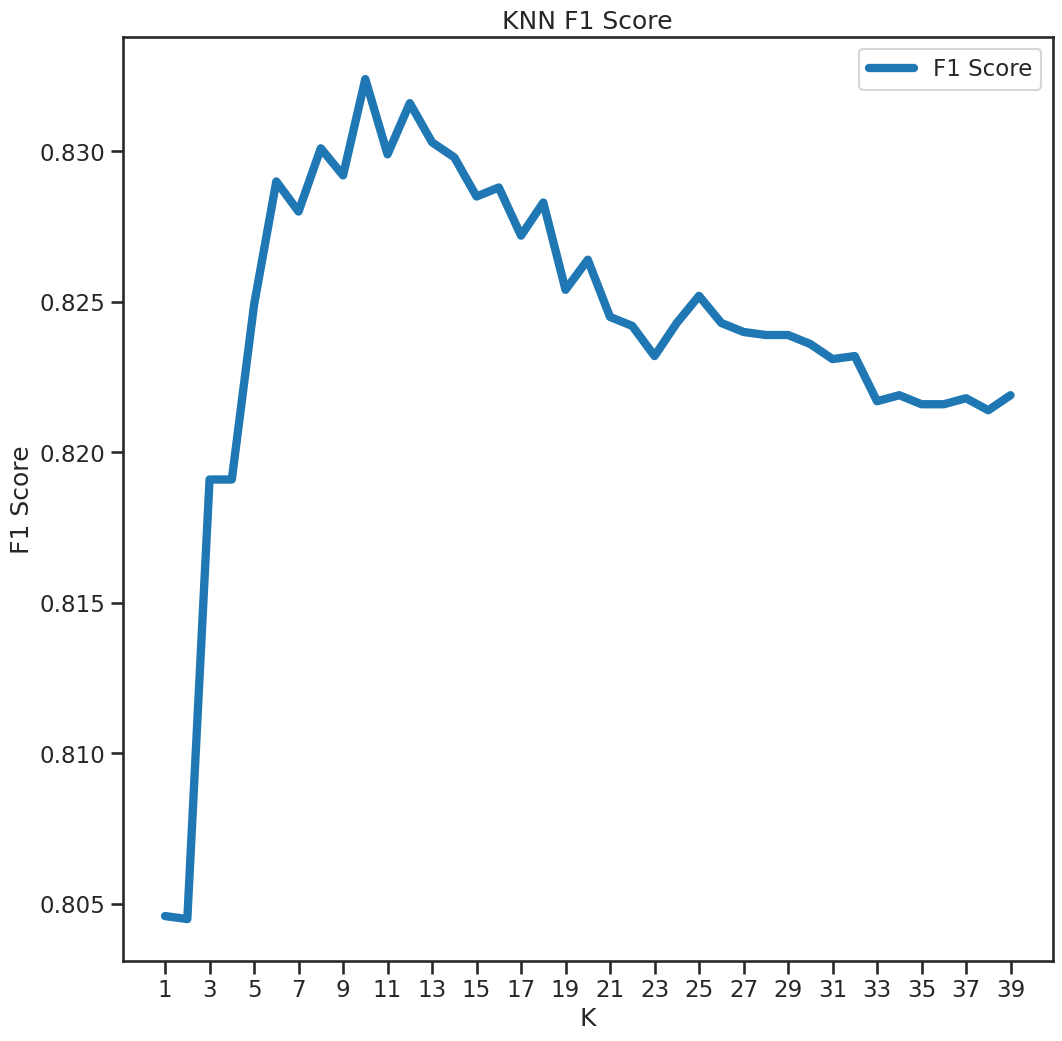

In [65]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 1920x1440 with 0 Axes>

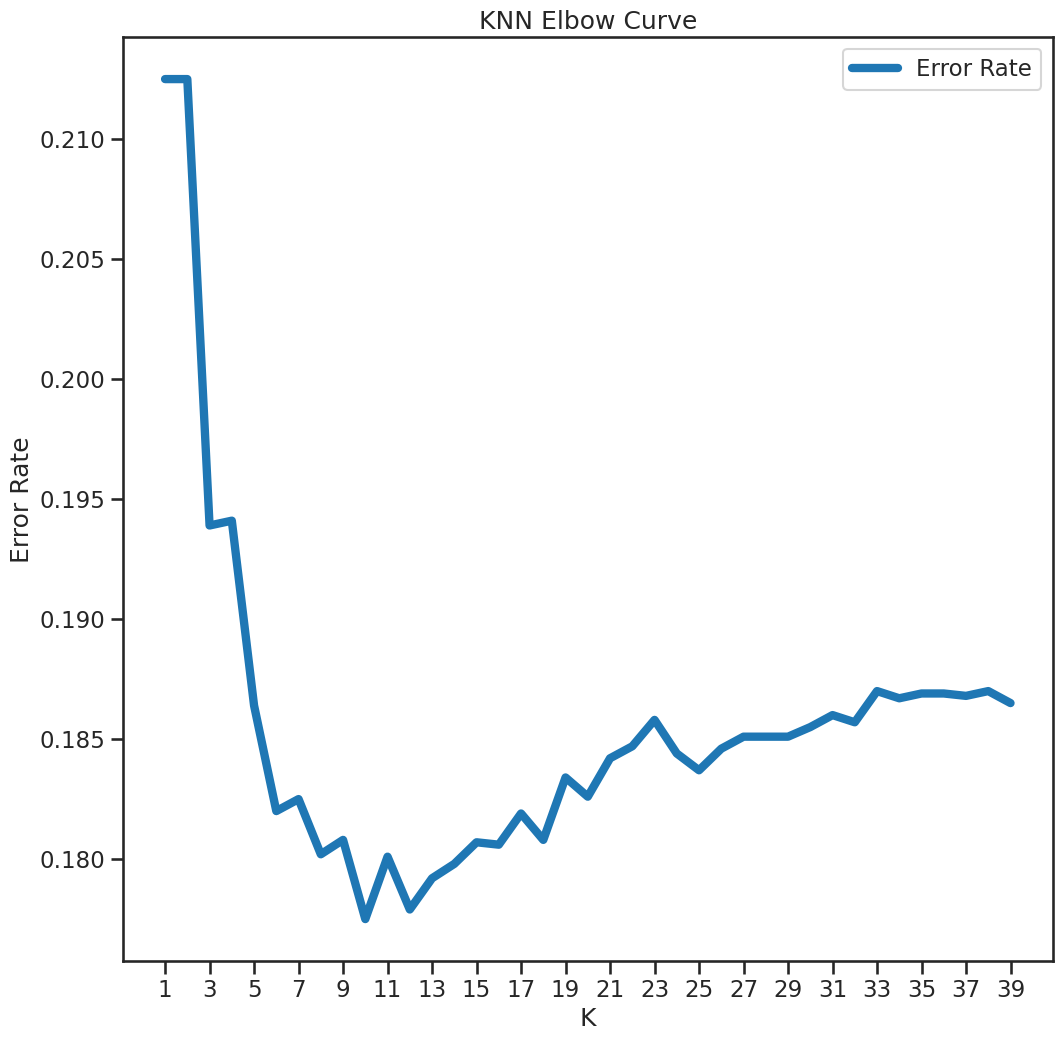

In [66]:
# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

In [67]:
# Create a KNN pipeline with PolynomialFeatures and StandardScaler
knn = make_pipeline(
    PolynomialFeatures(degree=2),   # Add polynomial features of degree 2
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=10, weights='distance')
)

# Train the pipeline on the training data
knn = knn.fit(X_train, y_train.values.ravel())

# Predict using the trained model
y_pred = knn.predict(X_test)

# Evaluate metrics and print results
evaluate_metrics(y_test, y_pred)

{'accuracy': 0.9185748875821516,
 'recall': array([0.90294522, 0.93153632]),
 'precision': array([0.91622793, 0.92047018]),
 'f1score': array([0.90953808, 0.92597019])}

In [68]:
plot_confusion_matrix(y_test,y_pred,"K-Nearest Neighbour")

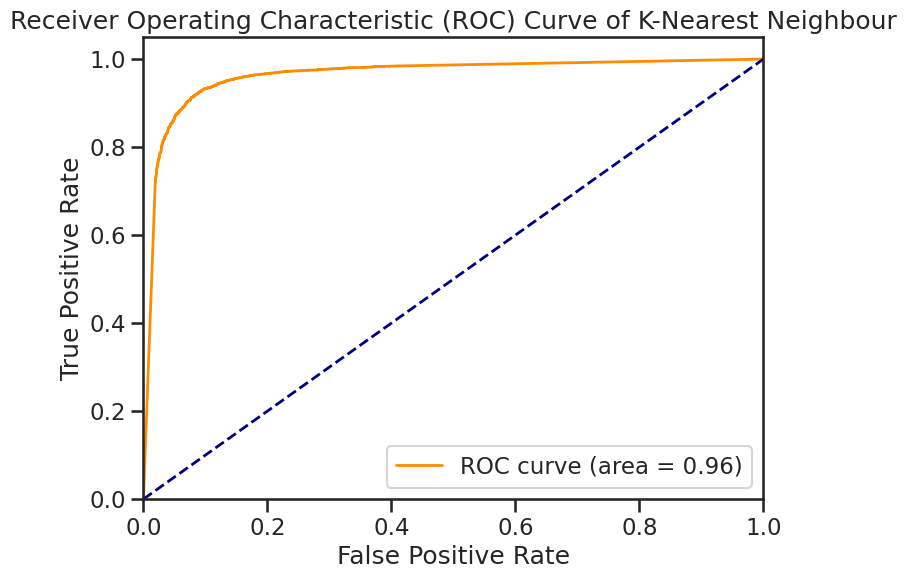

In [69]:
plot_ROC_curve(knn,"K-Nearest Neighbour")

## SVM - Support Vector Machines

### Hyperparameter Tuning of SVM

In [70]:
params_grid = {
    'C': [1, 10, 100],
    'kernel': ['poly', 'rbf', 'sigmoid']
}

In [71]:
model_svc = SVC()

In [73]:
# Define a GridSearchCV to search the best parameters
grid_search = GridSearchCV(estimator = model_svc, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1,n_jobs=-1)
# Search the best parameters with training data
grid_search.fit(X_train, y_train.values.ravel())
best_params = grid_search.best_params_

In [74]:
best_params

In [75]:
model = SVC(C=100, kernel='rbf')
model.fit(X_train, y_train.values.ravel())
preds = model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.8460740228294708,
 'recall': array([0.80711125, 0.87838522]),
 'precision': array([0.84624   , 0.84594759]),
 'f1score': array([0.82621261, 0.8618613 ])}

# Decision Tree

In [76]:
from sklearn.model_selection import StratifiedShuffleSplit

# Create a StratifiedShuffleSplit instance
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(X, y))

# Create the data sets
X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_test = X.loc[test_idx]
y_test = y.loc[test_idx]

- Now check the percent composition of each quality level in the train and test data sets. The data set is mostly Churn, as can be seen below.

In [77]:
y_train.value_counts(normalize=True).sort_index()

0    0.445857
1    0.554143
Name: churn, dtype: float64

In [78]:
y_test.value_counts(normalize=True).sort_index()

0    0.446
1    0.554
Name: churn, dtype: float64

In [79]:
# Create a DecisionTreeClassifier
tree_classifier = DecisionTreeClassifier(random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Create GridSearchCV instance
grid_search = GridSearchCV(tree_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [80]:
# Fit the GridSearchCV on your data
grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [81]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [82]:
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [83]:
train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,0.942672,0.933000
precision,0.957896,0.951763
recall,0.937766,0.925993
f1,0.947724,0.938701


In [86]:
evaluate_metrics(y_test,y_pred)

{'accuracy': 0.933,
 'recall': array([0.94170404, 0.92599278]),
 'precision': array([0.91106291, 0.95176252]),
 'f1score': array([0.9261301 , 0.93870082])}

In [87]:
from sklearn import tree
# Visulaize the decision treee
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(25, 20)) 
    tree.plot_tree(model, 
                       feature_names=feature_names,  
                       filled=True)
    plt.show()

In [88]:
feature_names = X.columns.values
feature_names

array(['is_tv_subscriber', 'is_movie_package_subscriber',
       'subscription_age', 'bill_avg', 'reamining_contract',
       'service_failure_count', 'download_avg', 'upload_avg',
       'download_over_limit'], dtype=object)

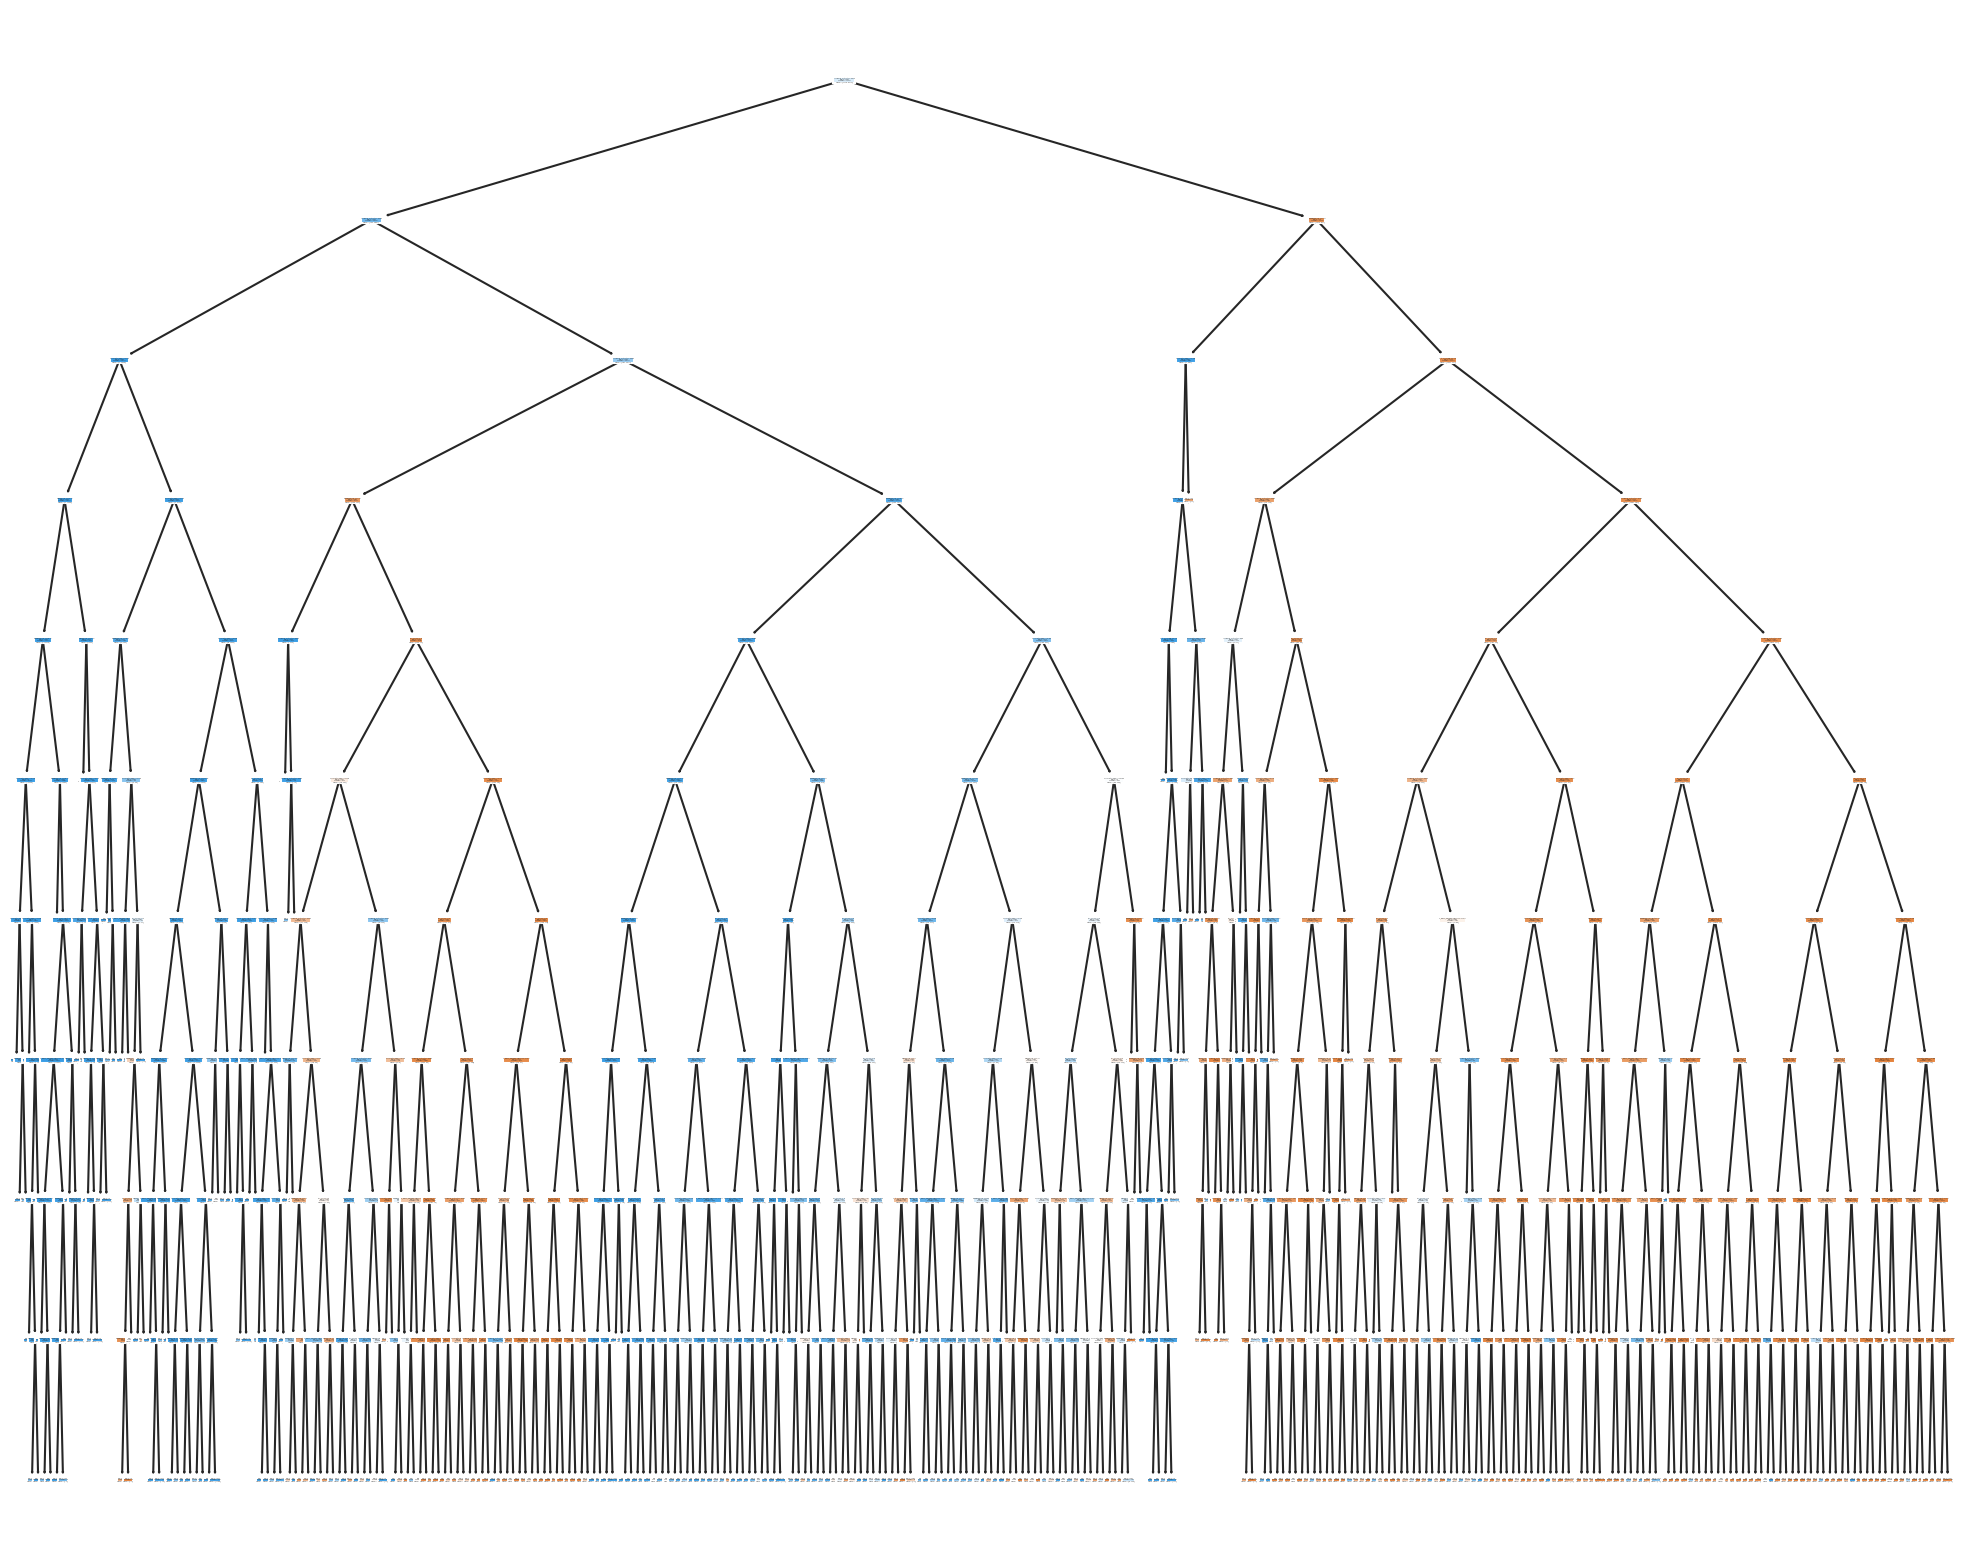

In [89]:
plot_decision_tree(best_model, feature_names)

# Algorithm Performance Summary

## 1. Logistic Regression (Baseline Model):
- **Accuracy:** 0.846
- **Recall (Churn):** 0.799
- **Recall (Retention):** 0.884
- **Precision (Churn):** 0.851
- **Precision (Retention):** 0.842
- **F1-Score (Churn):** 0.825
- **F1-Score (Retention):** 0.862

## 2. Logistic Regression with PCA:
- **Accuracy:** 0.791
- **Recall (Churn):** 0.720
- **Recall (Retention):** 0.850
- **Precision (Churn):** 0.800
- **Precision (Retention):** 0.785
- **F1-Score (Churn):** 0.757
- **F1-Score (Retention):** 0.817
- **Performance:** Decreased accuracy, recall, precision, and F1-score compared to baseline. PCA dimensionality reduction may have impacted model performance.

## 3. K-Nearest Neighbors (KNN):
- **Accuracy:** 0.919
- **Recall (Churn):** 0.903
- **Recall (Retention):** 0.932
- **Precision (Churn):** 0.916
- **Precision (Retention):** 0.920
- **F1-Score (Churn):** 0.910
- **F1-Score (Retention):** 0.926
- **Performance:** Improved accuracy, recall, precision, and F1-score compared to baseline.

## 4. Support Vector Machine (SVM):
- **Accuracy:** 0.846
- **Recall (Churn):** 0.807
- **Recall (Retention):** 0.878
- **Precision (Churn):** 0.846
- **Precision (Retention):** 0.846
- **F1-Score (Churn):** 0.826
- **F1-Score (Retention):** 0.862
- **Performance:** Similar accuracy, recall, precision, and F1-score compared to baseline.

## 5. Decision Tree:
- **Accuracy:** 0.933
- **Recall (Overall):** 0.926
- **Precision (Overall):** 0.952
- **F1-Score (Overall):** 0.939
- **Performance:** Improved accuracy, recall, precision, and F1-score compared to baseline. Decision Tree shows significant improvement in performance.

**In summary, K-Nearest Neighbors (KNN) and Decision Tree algorithms outperform the baseline Logistic Regression model in terms of accuracy, recall, precision, and F1-score. SVM performs similarly to the baseline, while Logistic Regression with PCA shows a decrease in performance, likely due to dimensionality reduction.**

# Recommended Final Model 
Based on the evaluation of various classifier models, I would recommend the Decision Tree as the final model that best aligns with our needs in terms of accuracy and explainability.

The Decision Tree model demonstrated a superior accuracy of 93.3%, outperforming the baseline Logistic Regression model. This indicates its robust ability to classify subscribers accurately, making it a strong candidate for deployment. Additionally, the Decision Tree achieved a commendable F1-score of 0.939, which is a balanced measure of precision and recall, showcasing its effectiveness in capturing both false positives and false negatives.

Moreover, the Decision Tree's inherent explainability is a noteworthy advantage. The model's decision-making process is easy to comprehend, as it forms a tree-like structure where each branch represents a decision based on feature thresholds. This transparency allows us to interpret and communicate the factors contributing to a subscriber's likelihood of churning, which is crucial for devising targeted retention strategies.

By choosing the Decision Tree as the final model, we strike a balance between accuracy and explainability, enabling us to not only predict potential churn cases with high confidence but also provide actionable insights to stakeholders. This model empowers us to make informed decisions regarding subscriber retention efforts, enhancing the internet service provider's ability to mitigate churn and optimize customer satisfaction.

# Summary: Key Findings and Insights

In our pursuit of addressing customer churn prediction for your internet service provider, we conducted a thorough analysis using various classifier models. The objective was to uncover the fundamental drivers of customer retention and provide actionable insights to inform your customer retention strategies effectively.

## Subscription Patterns and Service Usage

Our analysis reveals intriguing subscription patterns. A notable proportion of your customers do not engage in TV services or movie packages, and instances of customers subscribing to both are rare. This serves as a foundational insight, suggesting potential avenues for personalized offerings and package customization to enhance customer engagement.

## Addressing Service Failures

Around 17% of your customer base reported experiencing service failures. This concern should be a priority, as it plays a significant role in customer dissatisfaction and potential churn. Focusing on identifying and rectifying service issues can have a substantial positive impact on overall customer retention.

## Managing Download Limit Crossings

Approximately 7% of your customers have exceeded their internet download limits. This presents a potential pain point that may contribute to churn. By providing transparent usage monitoring and flexible plans, you can alleviate this concern and ensure a more satisfying customer experience.

## Contract Length and Retention

An important discovery is the substantial positive influence of remaining contract length on customer retention. Customers with longer remaining contract lengths tend to exhibit higher retention rates. This insight suggests that promoting longer-term contracts could be a strategic approach to improving customer retention.

## Model Performance and Recommendations

Our evaluations of classifier models offer valuable guidance for decision-making. While Logistic Regression with PCA experienced a performance decline due to dimensionality reduction, both K-Nearest Neighbors (KNN) and Decision Tree models demonstrated enhanced accuracy, recall, precision, and F1-score compared to the baseline.

**Recommendation: Decision Tree Model**

We recommend the Decision Tree as the final model due to its superior accuracy of 93.3% and balanced F1-score of 0.939. Notably, the Decision Tree offers inherent explainability, making it an ideal choice for comprehending the factors driving customer churn. Its tree-like structure facilitates easy interpretation and communication of these factors.

## Implications and Actionable Insights

Armed with these insights, you possess the means to proactively tailor retention strategies for specific subscriber segments. Addressing service failures and managing download limits directly impact customer satisfaction and churn prevention. Furthermore, promoting longer contract lengths and targeted offers for TV and movie packages can incentivize subscribers to remain loyal.

In conclusion, our analysis and modeling efforts have illuminated crucial drivers of customer churn and charted a clear course toward refining retention strategies. Equipped with these insights, you are well-prepared to make informed decisions and implement initiatives that align with your business objectives and amplify customer satisfaction.

# Suggestions for Further Analysis and Model Enhancement

As we delve deeper into the analysis of customer churn prediction for your internet service provider, there are several avenues to explore that can potentially lead to improved model explanation and prediction. Here are some recommended next steps:

## 1. Feature Engineering and Selection:
   - **Domain-Specific Features:** Consider creating new features that capture specific aspects of customer behavior or interaction with your services, such as customer support interactions or usage patterns during peak hours.
   - **Interaction Features:** Explore generating interaction features to capture potential synergies or correlations between existing features, providing a more comprehensive understanding of churn drivers.

## 2. Dimensionality Reduction:
   - **Advanced Techniques:** Experiment with advanced dimensionality reduction techniques like t-SNE (t-distributed Stochastic Neighbor Embedding) or UMAP (Uniform Manifold Approximation and Projection) to better capture complex relationships within the data.

## 3. Advanced Ensemble Algorithms:
   - **Bagging (Random Forest):** Implement bagging techniques, like the Random Forest algorithm, to build multiple decision trees and reduce overfitting while improving model accuracy.
   - **Boosting Algorithms:** Explore boosting techniques like AdaBoost or Gradient Boosting, which sequentially train models to correct misclassifications and enhance predictive performance.

## 4. Hyperparameter Tuning:
   - **Fine-Tuning:** Conduct thorough hyperparameter tuning for each algorithm considered to find the optimal configuration that maximizes model performance.

## 5. Validation and Cross-Validation:
   - **Time-Series Cross-Validation:** Utilize time-series cross-validation techniques to validate the model's performance on unseen data points, considering the temporal nature of the dataset.

## 6. Interpretable Models:
   - **Include Interpretable Models:** Alongside complex models, incorporate interpretable models like Logistic Regression or Naive Bayes to gain transparent insights into the factors influencing customer churn.

## 7. External Data:
   - **Incorporate External Data:** Explore the potential of integrating external data sources, such as economic indicators or market trends, to enrich the model's predictive capabilities.

## 8. Feedback Loop:
   - **Iterative Analysis:** Continuously assess the model's performance and gather feedback from real-world interventions. Regularly refine the model based on new data and insights obtained from practical applications.

By embracing these suggestions, including advanced feature engineering, dimensionality reduction, and experimenting with ensemble algorithms, you can unlock deeper insights within the data and potentially achieve a more accurate and interpretable model. This iterative approach ensures that your customer retention strategies are continually optimized, leading to improved outcomes and enhanced customer satisfaction.
